In [2]:
melbourne_file_path = "https://github.com/NikoStein/pds_data/raw/main/data/melb_data.csv"
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

## Missing Value Imputation

We just finished training our first machine learning models. To further improve the predictive power of the models we will have to work on our dataset.

We will start with handling missing values in the data. Most machine learning libraries (including scikit-learn) give an error if we try to build a model using data with missing values. So we'll need to choose a strategy to handle missing values.

We have already used a very simple strategy and dropped all rows containing missing values in the first example. To evaluate different approaches we will first load the full dataset and create a train-test split. (Note: As we cannot apply all imputation functions (e.g., mean) to categorical data we will only use numerical predictions in this simple example.)

In [3]:
# Load dataset
data = pd.read_csv(melbourne_file_path)

# Target variable
y = data['Price']

# Drop non-numeric variables
melb_predictors = data.drop(['Price'], axis=1)
X = melb_predictors.select_dtypes(exclude=['object'])

# Train-test split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=0)

### Simple Imputation

One popular way to handle missing values is called imputation. Here, we fill in the missing values with some number. For instance, we can fill in the mean value along each column. The imputed value won't be exactly right in most cases, but it usually leads to more accurate models than you would get from dropping the column entirely.

In [4]:
from sklearn.impute import SimpleImputer

In [5]:
# Imputation
simple_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(simple_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(simple_imputer.transform(X_valid))



In [6]:
# "Repair" column names
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

In [7]:
imputed_X_train.shape

(10864, 12)

To evaluate the performance of the approach, we modify our helper function (get_mae) to train and evaluate our model on different datasets:

In [8]:
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(random_state=1, n_estimators=500, max_features="log2")
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

In [9]:
mae_imputation = score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid)
print("MAE using Imputation: {}".format(mae_imputation))

MAE using Imputation: 165214.23266251883


### Advanced Imputation

We see that the imputation approach performs much better compared to the simple solution dropping all rows with NA values.

Imputation is the standard approach, and it usually works well. However, imputed values may be systematically above or below their actual values (which weren't collected in the dataset). Or rows with missing values may be unique in some other way. In that case, your model would make better predictions by considering which values were originally missing.

In the advanced imputation approach, we impute the missing values, as before. And, additionally, for each column with missing entries in the original dataset, we add a new column that shows the location of the imputed entries.

In [10]:
# Make a copy of the original datasets to avoid changing the original data frame
X_train_plus = X_train.copy()
X_valid_plus = X_valid.copy()

# Find all columns with missing values:
cols_with_missing = X_train.columns.values[X_train.isna().sum() > 0]

# Make new columns indicating what will be imputed
for col in cols_with_missing:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_valid_plus[col + '_was_missing'] = X_valid_plus[col].isnull()

# Imputation
simple_imputer = SimpleImputer()
imputed_X_train_plus = pd.DataFrame(simple_imputer.fit_transform(X_train_plus))
imputed_X_valid_plus = pd.DataFrame(simple_imputer.transform(X_valid_plus))

# "Repair" column names
imputed_X_train_plus.columns = X_train_plus.columns
imputed_X_valid_plus.columns = X_valid_plus.columns

In [11]:
imputed_X_train_plus.shape

(10864, 15)

In [12]:
imputed_X_train_plus

,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount,Car_was_missing,BuildingArea_was_missing,YearBuilt_was_missing
0,1.0,5.0,3182.0,1.0,1.0,1.0,0.0,153.764119,1940.000000,-37.85984,144.98670,13240.0,0.0,1.0,0.0
1,2.0,8.0,3016.0,2.0,2.0,1.0,193.0,153.764119,1964.839866,-37.85800,144.90050,6380.0,0.0,1.0,1.0
2,3.0,12.6,3020.0,3.0,1.0,1.0,555.0,153.764119,1964.839866,-37.79880,144.82200,3755.0,0.0,1.0,1.0
3,3.0,13.0,3046.0,3.0,1.0,1.0,265.0,153.764119,1995.000000,-37.70830,144.91580,8870.0,0.0,1.0,0.0
4,3.0,13.3,3020.0,3.0,1.0,2.0,673.0,673.000000,1970.000000,-37.76230,144.82720,4217.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10859,3.0,5.2,3056.0,3.0,1.0,2.0,212.0,153.764119,1964.839866,-37.77695,144.95785,11918.0,0.0,1.0,1.0
10860,3.0,10.5,3081.0,3.0,1.0,1.0,748.0,101.000000,1950.000000,-37.74160,145.04810,2947.0,0.0,0.0,0.0
10861,4.0,6.7,3058.0,4.0,2.0,2.0,441.0,255.000000,2002.000000,-37.73572,144.97256,11204.0,0.0,0.0,0.0
10862,3.0,12.0,3073.0,3.0,1.0,1.0,606.0,153.764119,1964.839866,-37.72057,145.02615,21650.0,0.0,1.0,1.0


In [13]:
mae_imputation_advanced = score_dataset(imputed_X_train_plus, imputed_X_valid_plus, y_train, y_valid)
print("MAE using Imputation: {}".format(mae_imputation_advanced))

MAE using Imputation: 168740.6031281647


As we see, advanced imputation does not improve the performance of our model in the problem at hand.

In [14]:
# Make a copy of the original datasets to avoid changing the original data frame
X_train_knn = X_train.copy()
X_valid_knn = X_valid.copy()

from sklearn.impute import KNNImputer

# Imputation
knn_imputer = KNNImputer()
X_train_knn = pd.DataFrame(knn_imputer.fit_transform(X_train_plus))
X_valid_knn = pd.DataFrame(knn_imputer.transform(X_valid_plus))

# "Repair" column names
X_train_knn.columns = X_train_plus.columns
X_valid_knn.columns = X_valid_plus.columns

In [15]:
mae_imputation_knn = score_dataset(X_train_knn, X_valid_knn, y_train, y_valid)
print("MAE using Imputation: {}".format(mae_imputation_knn))

MAE using Imputation: 168960.53086425533


## Encoding Categorical Variables

Until now we only used numerical features for our models. However, valuable information is often encoded in categorical variables (e.g., gender, city, job).

If we simply plug these variables into machine learning models we will get an error. Hence, we need to find an  appropriate preprocessing to capture the information hidden in categorical variables.

The easiest approach to deal with categorical variables is to drop them from the dataset (that is what we have done before). However, this approach will only produce satisfying results if the dropped columns did not contain useful information.

### Label Encoding

One common approach to handle categorical variables is called label encoding. Here, we assign each unique value to a different integer (e.g., bad = 0, neutral = 1, good = 2). This assumption makes sense in this example, because there is an indisputable ranking to the categories. Not all categorical variables have a clear ordering in the values, but we refer to those that do as ordinal variables. For tree-based models (like decision trees and random forests), you can expect label encoding to work well with ordinal variables.

For simplicity, we will drop columns with missing values for the following evaluation.

In [16]:
# Load dataset
data = pd.read_csv(melbourne_file_path)

# Drop NA
data.dropna(axis=0, inplace=True)

# Separate target from predictors
y = data['Price']
X = data.drop(['Price'], axis=1)

# Train-test split
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=0)

As we do not want to use all categorical variables we focus on those with a limited number of categories:

In [17]:
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and
                        X_train_full[cname].dtype == "object"]

print(low_cardinality_cols)

['Type', 'Method', 'Regionname']


...and combine them with the numerical variables:

In [18]:
# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep only selected columns
cols_to_keep = low_cardinality_cols + numerical_cols
cols_to_keep

['Type',
 'Method',
 'Regionname',
 'Rooms',
 'Distance',
 'Postcode',
 'Bedroom2',
 'Bathroom',
 'Car',
 'Landsize',
 'BuildingArea',
 'YearBuilt',
 'Lattitude',
 'Longtitude',
 'Propertycount']

In [19]:
X_train = X_train_full[cols_to_keep].copy()
X_valid = X_valid_full[cols_to_keep].copy()

X_train.head()

,Type,Method,Regionname,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
6584,u,VB,Southern Metropolitan,2,5.1,3181.0,2.0,1.0,1.0,0.0,71.0,1970.0,-37.85550,145.00180,4380.0
11369,h,S,South-Eastern Metropolitan,3,38.0,3199.0,3.0,1.0,4.0,578.0,123.0,1984.0,-38.13743,145.16702,17055.0
11942,h,S,South-Eastern Metropolitan,5,27.0,3196.0,5.0,5.0,4.0,570.0,243.0,1990.0,-38.03335,145.13212,2076.0
5830,u,VB,Southern Metropolitan,1,6.1,3182.0,1.0,1.0,1.0,0.0,52.0,2012.0,-37.86760,144.99010,13240.0
1717,u,VB,Southern Metropolitan,2,11.4,3163.0,2.0,1.0,1.0,0.0,70.0,1970.0,-37.90320,145.05550,7822.0


We can now perform label encoding on our new dataset using the functions provided by Scikit-learn. Subsequently, we can evaluate our approach by using our score_dataset utility function.

In [20]:
from sklearn.preprocessing import LabelEncoder

In [21]:
low_cardinality_cols

['Type', 'Method', 'Regionname']

In [22]:
# Make a copy to protect original data
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()

# Apply label encoder
label_encoder = LabelEncoder()
for col in low_cardinality_cols:
    label_X_train[col] = label_encoder.fit_transform(X_train[col])
    label_X_valid[col] = label_encoder.transform(X_valid[col])


# Evaluate performance
mae_label_encoding = score_dataset(label_X_train, label_X_valid, y_train, y_valid)
print("MAE using Label Encoding: {}".format(mae_label_encoding))

MAE using Label Encoding: 175110.11428387096


In [23]:
label_X_train

,Type,Method,Regionname,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
6584,2,4,5,2,5.1,3181.0,2.0,1.0,1.0,0.0,71.0,1970.0,-37.85550,145.00180,4380.0
11369,0,1,4,3,38.0,3199.0,3.0,1.0,4.0,578.0,123.0,1984.0,-38.13743,145.16702,17055.0
11942,0,1,4,5,27.0,3196.0,5.0,5.0,4.0,570.0,243.0,1990.0,-38.03335,145.13212,2076.0
5830,2,4,5,1,6.1,3182.0,1.0,1.0,1.0,0.0,52.0,2012.0,-37.86760,144.99010,13240.0
1717,2,4,5,2,11.4,3163.0,2.0,1.0,1.0,0.0,70.0,1970.0,-37.90320,145.05550,7822.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9510,0,0,2,3,1.3,3002.0,3.0,1.0,0.0,118.0,177.0,1890.0,-37.81351,144.98804,3040.0
6023,0,1,6,5,13.3,3020.0,5.0,2.0,2.0,661.0,133.0,1960.0,-37.76510,144.82410,4217.0
2960,0,0,6,4,13.6,3043.0,4.0,2.0,2.0,453.0,213.0,2007.0,-37.70160,144.89740,1071.0
4729,0,4,5,2,3.8,3207.0,2.0,1.0,1.0,90.0,106.0,2007.0,-37.83570,144.93760,8648.0


### One-hot Encoding

One-hot encoding creates new binary columns indicating the presence (or absence) of each possible value in the original data.

In contrast to label encoding, one-hot encoding does not assume an ordering of the categories. Thus, you can expect this approach to work particularly well if there is no clear ordering in the categorical data. We refer to categorical variables without an intrinsic ranking as nominal variables.

One-hot encoding generally does not perform well if the categorical variable takes on a large number of values (i.e., you generally won't use it for variables taking more than 15 different values).

Again, we can use Scikit-learn functions to implement one-hot encodings:

In [24]:
from sklearn.preprocessing import OneHotEncoder

In [25]:
# Apply one-hot encoder to each column with categorical data
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
one_hot_cols_train = pd.DataFrame(one_hot_encoder.fit_transform(X_train[low_cardinality_cols]))
one_hot_cols_valid = pd.DataFrame(one_hot_encoder.transform(X_valid[low_cardinality_cols]))

# Repair index
one_hot_cols_train.index = X_train.index
one_hot_cols_valid.index = X_valid.index

# Remove categorical columns and replace with one-hot encoding
num_X_train = X_train.drop(low_cardinality_cols, axis=1)
num_X_valid = X_valid.drop(low_cardinality_cols, axis=1)
one_hot_X_train = pd.concat([num_X_train, one_hot_cols_train], axis=1)
one_hot_X_valid = pd.concat([num_X_valid, one_hot_cols_valid], axis=1)
one_hot_X_train.columns = one_hot_X_train.columns.astype(str)
one_hot_X_valid.columns = one_hot_X_train.columns.astype(str)

# Evaluate performance

one_hot_encoding = score_dataset(one_hot_X_train, one_hot_X_valid, y_train, y_valid)
print("MAE using One-hot Encoding: {}".format(one_hot_encoding))

MAE using One-hot Encoding: 177614.6387064516


In [26]:
one_hot_X_train

,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,...,6,7,8,9,10,11,12,13,14,15
6584,2,5.1,3181.0,2.0,1.0,1.0,0.0,71.0,1970.0,-37.85550,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11369,3,38.0,3199.0,3.0,1.0,4.0,578.0,123.0,1984.0,-38.13743,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
11942,5,27.0,3196.0,5.0,5.0,4.0,570.0,243.0,1990.0,-38.03335,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5830,1,6.1,3182.0,1.0,1.0,1.0,0.0,52.0,2012.0,-37.86760,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1717,2,11.4,3163.0,2.0,1.0,1.0,0.0,70.0,1970.0,-37.90320,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9510,3,1.3,3002.0,3.0,1.0,0.0,118.0,177.0,1890.0,-37.81351,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6023,5,13.3,3020.0,5.0,2.0,2.0,661.0,133.0,1960.0,-37.76510,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2960,4,13.6,3043.0,4.0,2.0,2.0,453.0,213.0,2007.0,-37.70160,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4729,2,3.8,3207.0,2.0,1.0,1.0,90.0,106.0,2007.0,-37.83570,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Creating Model Pipelines

Up to now, we learned how to prepare our datasets, train, tune, and evaluate powerful models. However, we wrote lots of code and functions to perform all the required tasks. Scikit-learn pipelines are a simple way to keep our data preprocessing and modeling code organized. Specifically, a pipeline bundles preprocessing and modeling steps so we can use the whole bundle as if it were a single step.

Using pipelines provides multiple benefits:
* Cleaner Code
* Fewer Bugs
* Easier to Productionize
* More Options for Model Validation

We will build a pipeline using all numerical variables as well as the low cardinatlity categorical variables

In [27]:
# Load dataset
data = pd.read_csv(melbourne_file_path)

# Separate target from predictors
y = data['Price']

X = data[cols_to_keep]

# Train-test split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=0)
X_train.head()

,Type,Method,Regionname,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
12167,u,S,Southern Metropolitan,1,5.0,3182.0,1.0,1.0,1.0,0.0,NaN,1940.0,-37.85984,144.9867,13240.0
6524,h,SA,Western Metropolitan,2,8.0,3016.0,2.0,2.0,1.0,193.0,NaN,NaN,-37.85800,144.9005,6380.0
8413,h,S,Western Metropolitan,3,12.6,3020.0,3.0,1.0,1.0,555.0,NaN,NaN,-37.79880,144.8220,3755.0
2919,u,SP,Northern Metropolitan,3,13.0,3046.0,3.0,1.0,1.0,265.0,NaN,1995.0,-37.70830,144.9158,8870.0
6043,h,S,Western Metropolitan,3,13.3,3020.0,3.0,1.0,2.0,673.0,673.0,1970.0,-37.76230,144.8272,4217.0


Writing a pipeline in Scikit-learn can be broken down into 3 steps:
1. Define preprocessing steps
2. Define the model
3. Create and evaluate the pipeline

### Define Preprocessing steps

We use the ``ColumnTransformer`` class to bundle together different preprocessing steps. To this end, we will impute missing values in the numerical columns and impute missing values and use one-hot encoding in the categorical columns.

In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [29]:
# Preprocessing numerical columns
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle both preprocessors
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, low_cardinality_cols)
])

### Define the Model
Next, we define a random forest model.

In [30]:
model_rf = RandomForestRegressor(random_state=1, n_estimators=350, max_features="log2")

### Create and Evaluate the Pipeline

Finally, we use the ``Pipeline`` class to define a pipeline that bundles the preprocessing and modeling steps. There are a few important things to notice:

* With the pipeline, we preprocess the training data and fit the model in a single line of code. (In contrast, without a pipeline, we have to do imputation, one-hot encoding, and model training in separate steps. This becomes especially messy if we have to deal with both numerical and categorical variables!)
* With the pipeline, we supply the unprocessed features in X_valid to the predict() command, and the pipeline automatically preprocesses the features before generating predictions. (However, without a pipeline, we have to remember to preprocess the validation data before making predictions.)

In [31]:
# Bundle preprocessing and modeling code in a pipeline
complete_pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model_rf)
])

# Preprocess the raw training data and fit the model
complete_pipeline_rf.fit(X_train, y_train)

# Preprocess the raw validation data and make predictions
preds = complete_pipeline_rf.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print("MAE using the complete random forest pipeline: {}".format(score))

NameError: name 'score' is not defined

In [ ]:
complete_pipeline_rf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Rooms', 'Distance',
                                                   'Postcode', 'Bedroom2',
                                                   'Bathroom', 'Car',
                                                   'Landsize', 'BuildingArea',
                                                   'YearBuilt', 'Lattitude',
                                                   'Longtitude',
                                                   'Propertycount']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Type', 'Method',
                                                   'Regionname'])])),
                ('model',
                 RandomForestRegressor(max_features='log2', n_estimators=350,
                                       random_state=1))])

In [ ]:
complete_pipeline_rf.steps[1][1]

RandomForestRegressor(max_features='log2', n_estimators=350, random_state=1)

In [ ]:
complete_pipeline_rf.named_steps['model'].feature_importances_

array([0.06714545, 0.09449226, 0.06968446, 0.06441794, 0.06394141,
       0.02451411, 0.08367541, 0.07203634, 0.04536212, 0.08505158,
       0.07661148, 0.03155538, 0.05189888, 0.00444364, 0.04755613,
       0.00515908, 0.00639738, 0.000334  , 0.00285143, 0.00356588,
       0.00479284, 0.00042308, 0.00678557, 0.00016863, 0.00307178,
       0.07437888, 0.00942454, 0.00026031])

In [ ]:
X_train.columns

Index(['Type', 'Method', 'Regionname', 'Rooms', 'Distance', 'Postcode',
       'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt',
       'Lattitude', 'Longtitude', 'Propertycount'],
      dtype='object')

In [ ]:
complete_pipeline_rf.named_steps['preprocessor'].named_transformers_['cat'][1]

OneHotEncoder(handle_unknown='ignore')

In [ ]:
onehot_columns = complete_pipeline_rf.named_steps['preprocessor'].named_transformers_['cat'][1].get_feature_names_out(low_cardinality_cols)

In [ ]:
onehot_columns

array(['Type_h', 'Type_t', 'Type_u', 'Method_PI', 'Method_S', 'Method_SA',
       'Method_SP', 'Method_VB', 'Regionname_Eastern Metropolitan',
       'Regionname_Eastern Victoria', 'Regionname_Northern Metropolitan',
       'Regionname_Northern Victoria',
       'Regionname_South-Eastern Metropolitan',
       'Regionname_Southern Metropolitan',
       'Regionname_Western Metropolitan', 'Regionname_Western Victoria'],
      dtype=object)

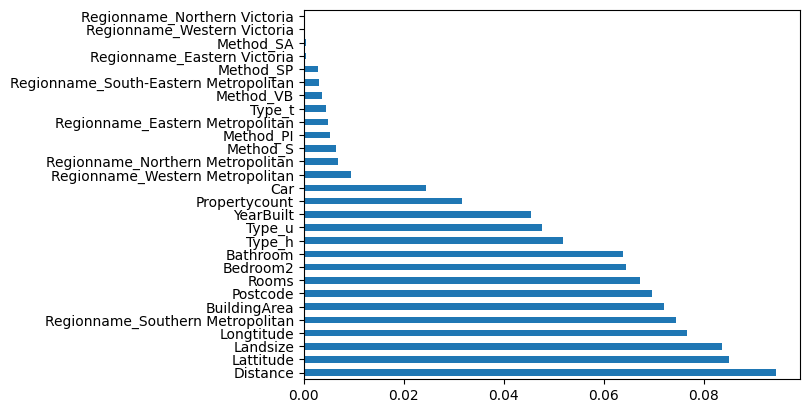

In [ ]:
feat_importances = pd.Series(complete_pipeline_rf.steps[1][1].feature_importances_)
feat_importances.index = list(X_train.columns[3:])+list(onehot_columns)
feat_importances.nlargest(40).plot(kind='barh');


## Wrapping up

In this lecture we learned how to build powerful machine learning models leveraging numerical as well as categorical variables. Additionally, we learned about model pipelines which are helpful for creating reproducible and understandable code.

To keep improving, view the [scikit-learn documentation](https://scikit-learn.org/stable/) and keep working on your own projects!

## It's your turn now!

Apply the basic learnings to set up a classification pipeline for the titanic dataset from seaborn.

In [ ]:
import seaborn as sns

In [ ]:
titanic = sns.load_dataset("titanic")

In [ ]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [ ]:
y = titanic['survived']
titanicClean = titanic[['sex','age','sibsp','parch','fare','embark_town','class','deck','alone']].copy()

In [ ]:
titanicClean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   sex          891 non-null    object  
 1   age          714 non-null    float64 
 2   sibsp        891 non-null    int64   
 3   parch        891 non-null    int64   
 4   fare         891 non-null    float64 
 5   embark_town  889 non-null    object  
 6   class        891 non-null    category
 7   deck         203 non-null    category
 8   alone        891 non-null    bool    
dtypes: bool(1), category(2), float64(2), int64(2), object(2)
memory usage: 45.0+ KB


In [ ]:
X = titanicClean

In [ ]:
titanicClean.head()

,sex,age,sibsp,parch,fare,embark_town,class,deck,alone
0,male,22.0,1,0,7.2500,Southampton,Third,NaN,False
1,female,38.0,1,0,71.2833,Cherbourg,First,C,False
2,female,26.0,0,0,7.9250,Southampton,Third,NaN,True
3,female,35.0,1,0,53.1000,Southampton,First,C,False
4,male,35.0,0,0,8.0500,Southampton,Third,NaN,True


Of course survived is our target variable - which in this case means we need to do classification! https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html should get you started on what actually changes in this case.

In [ ]:
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64', 'bool']]

In [ ]:
numerical_cols

['age', 'sibsp', 'parch', 'fare', 'alone']

In [ ]:
meanImputeColumns = ['age', 'fare']
medianImputeColumns = ['sibsp', 'parch', 'alone']

In [ ]:
categorical_cols = [cname for cname in X.columns if X[cname].dtype in ["object","category"]]


In [ ]:
categorical_cols

['sex', 'embark_town', 'class', 'deck']

In [ ]:
categorical_cols = ['sex', 'embark_town', 'class', 'deck']

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Preprocessing numerical columns
numerical_transformer1 = SimpleImputer(strategy='median')
numerical_transformer2 = SimpleImputer(strategy='mean')

# Preprocessing categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle both preprocessors
preprocessor = ColumnTransformer(transformers=[
    ('num1', numerical_transformer1, medianImputeColumns),
    ('num2', numerical_transformer2, meanImputeColumns),
    ('cat', categorical_transformer, categorical_cols)
])



In [ ]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=0)
X_train.head()

,sex,age,sibsp,parch,fare,embark_town,class,deck,alone
140,female,NaN,0,2,15.2458,Cherbourg,Third,NaN,False
439,male,31.0,0,0,10.5000,Southampton,Second,NaN,True
817,male,31.0,1,1,37.0042,Cherbourg,Second,NaN,False
378,male,20.0,0,0,4.0125,Cherbourg,Third,NaN,True
491,male,21.0,0,0,7.2500,Southampton,Third,NaN,True


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

model_rf_classifier = RandomForestClassifier(random_state=1, n_estimators=350, max_features="log2")

In [ ]:
# Bundle preprocessing and modeling code in a pipeline
complete_pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model_rf_classifier)
])

# Preprocess the raw training data and fit the model
complete_pipeline_rf.fit(X_train, y_train)

# Preprocess the raw validation data and make predictions
preds = complete_pipeline_rf.predict(X_valid)

# Evaluate the model
score = accuracy_score(y_valid, preds)
print("Accuracy using the complete random forest pipeline: {}".format(score))

Accuracy using the complete random forest pipeline: 0.8435754189944135


In [ ]:
complete_pipeline_rf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num1',
                                                  SimpleImputer(strategy='median'),
                                                  ['sibsp', 'parch', 'alone']),
                                                 ('num2', SimpleImputer(),
                                                  ['age', 'fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'embark_town',
                                                   'class', 'deck'])])),
                ('model',
                 RandomForestClassifier(max_features='log2', n_estimators=350,
                                        random_state=1))])

## Revisiting the salaries Dataset

In [34]:
salaries = pd.read_csv("Salaries.csv", sep=";")
y = salaries['salary']
X = salaries.drop('salary', axis=1)

In [36]:
X

,rank,discipline,phd,service,sex
0,Prof,B,56,49,Male
1,Prof,A,12,6,Male
2,Prof,A,23,20,Male
3,Prof,A,40,31,Male
4,Prof,B,20,18,Male
...,...,...,...,...,...
73,Prof,B,18,10,Female
74,AssocProf,B,19,6,Female
75,Prof,B,17,17,Female
76,Prof,A,28,14,Female


In [41]:
salaries['rank'].unique()

array(['Prof', 'AssocProf', 'AsstProf'], dtype=object)

In [43]:
from sklearn.preprocessing import OrdinalEncoder


rank_order = ['AsstProf', 'AssocProf', 'Prof']

# Preprocessing categorical columns
onehot_transformer = Pipeline(steps=[
    ('onehotTransformer', OneHotEncoder())
])

ordinal_transformer = Pipeline(steps=[
    ('ordinalTransformer', OrdinalEncoder(categories=[rank_order]))
])

# Bundle both preprocessors
preprocessor = ColumnTransformer(transformers=[
    ('onehot', categorical_transformer, ["discipline","sex"]),
    ('ordinal', ordinal_transformer, ["rank"])
])

In [58]:
from sklearn.linear_model import Lasso
lasso_model = Lasso()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=0)
X_train.head()

# Bundle preprocessing and modeling code in a pipeline
complete_pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lasso_model)
])

# Preprocess the raw training data and fit the model
complete_pipeline_rf.fit(X_train, y_train)

# Preprocess the raw validation data and make predictions
preds = complete_pipeline_rf.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print("MAE using the complete random forest pipeline: {}".format(score))

MAE using the complete random forest pipeline: 13832.515549735539
